## GR5241 Homework 4
### Name: Kangshuo Li           UNI: kl3259

<br>

![](GR5241_HW4_Q5_1.png)
![](GR5241_HW4_Q5_2.png)
![](GR5241_HW4_Q5_3.png)
![](GR5241_HW4_Q5_4.png)

#### Setup

In [165]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import os
import time
%xmode plain
os.getcwd()

Exception reporting mode: Plain


'/Users/kangshuoli/Documents/VScode_workspace/GR5241/GR5241_HW4'

#### Read in data

In [166]:
feature_df = pd.read_csv("features.txt", header = None)
target_df = pd.read_csv("target.txt", header = None)
assert feature_df.shape == (6414,122)
assert target_df.shape == (6414, 1)

#### 5.
##### (a)

In [178]:
def my_SVM(method, x_ = feature_df, y_ = target_df):
    n = x_.shape[0]
    d = x_.shape[1]
    oens = np.ones(n) # n * 1
    y_ = np.array(y_).ravel()
    f = lambda x: max(0, x)
    def L(w, b, x_, y_):
        temp_vec = np.array(1 - y_ * (x_ @ w + b)).reshape(-1, 1)
        return np.array(np.apply_along_axis(lambda x: max(x, 0), 1, temp_vec)).ravel() # shape: (n,)

    def cost(w, b, C, x_ = x_, y_ = y_):
        sum_L = np.sum(L(w, b, x_, y_))
        return (1 / 2) * w.T @ w + C * sum_L

    def gradient_w(w, b, x_, y_, C, filter_index):
        L_gradient_mat = np.array(- y_.reshape(-1, 1) * x_)
        L_gradient_mat = L_gradient_mat[filter_index,:]
        sum_L_gradient = np.sum(L_gradient_mat, axis = 0) # (d,)
        return w + C * sum_L_gradient

    def gradient_w_i(w, b, x_i, y_i, C, filter_index_i):
        if filter_index_i == False:
            return w
        else:
            sum_L_gradient = np.array(- y_i * x_i).ravel() # (d,)
        return w + C * sum_L_gradient

    def gradient_w_l(w, b, x_l, y_l, C, sub_filter_index):
        L_gradient_mat = np.array(- y_l.reshape(-1, 1) * x_l)
        L_gradient_mat = L_gradient_mat[sub_filter_index,:]
        sum_L_gradient = np.sum(L_gradient_mat, axis = 0) # (d,)
        return w + C * sum_L_gradient

    def gradient_b(w, b, x_, y_, C, filter_index):
        L_gradient_vec = - y_
        L_gradient_vec = L_gradient_vec[filter_index]
        sum_L_gradient = np.sum(L_gradient_vec, axis = 0)
        return  C * sum_L_gradient

    def gradient_b_i(w, b, x_i, y_i, C, filter_index_i):
        if filter_index_i == False:
            return 0
        else:
            return C * (- y_i)

    def gradient_b_l(w, b, x_l, y_l, C, sub_filter_index):
        L_gradient_vec = - y_l
        L_gradient_vec = L_gradient_vec[sub_filter_index]
        sum_L_gradient = np.sum(L_gradient_vec, axis = 0)
        return  C * sum_L_gradient

    #---------------------------------------------------------------------------------------

    def my_batchGD(ita = 0.0000003, epsilon = 0.25, C = 100, x_ = x_, y_ = y_):
        k = 0
        cost_list = [] # f_k(w, b)
        w = np.zeros((d,)) # (d,)
        b = 0
        cost_list.append(cost(w, b, C, x_ = x_, y_ = y_)) # f_0(w, b)
        conv_crit = 100
        while conv_crit > epsilon:
            prev_w = w
            curr_L = L(prev_w, b, x_, y_) # (n,)
            filter_index_list = (curr_L > 0)
            # vectorize
            w -= ita * gradient_w(prev_w, b, x_, y_, C, filter_index_list)
            b -= ita * gradient_b(prev_w, b, x_, y_, C, filter_index_list)
            k += 1
            cost_list.append(cost(w, b, C, x_ = x_, y_ = y_))
            conv_crit = 100 * np.abs(cost_list[k - 1] - cost_list[k]) / (cost_list[k - 1])
        return w, b, cost_list, k

    def my_SGD(ita = 0.0001, epsilon = 0.001, C = 100, x_ = x_, y_ = y_):
        # shuffle the data
        from sklearn.utils import shuffle
        x_shuffled, y_shuffled = shuffle(
            x_, y_, 
            random_state = 42
        )
        # reindexing
        x_shuffled.index = np.arange(n, dtype = int)
        i = 1
        k = 0
        cost_list = []
        delta_cost_list = []
        delta_cost_list.append(0) # delta_cost = 0
        w = np.zeros((d,)) # (d,)
        b = 0
        cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled)) # f_0(w, b)
        conv_crit = 100
        while conv_crit > epsilon:
            prev_w = w
            curr_L = L(prev_w, b, x_shuffled, y_shuffled) # (n,)
            filter_index_list = (curr_L > 0)
            w -= ita * gradient_w_i(prev_w, b, x_shuffled.iloc[i,:].T, y_shuffled[i], C, filter_index_list[i])
            b -= ita * gradient_b_i(prev_w, b, x_shuffled.iloc[i,:].T, y_shuffled[i], C, filter_index_list[i])
            i = (i % n) + 1
            k += 1
            cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled))
            delta_cost_percentage = 100 * np.abs(cost_list[k - 1] - cost_list[k]) / (cost_list[k - 1])
            delta_cost_list.append(0.5 * delta_cost_percentage + 0.5 * delta_cost_list[k - 1])
            conv_crit = delta_cost_list[k]
        return w, b, cost_list, k

    def my_MiniBatchGD(batch_size = 20, ita = 0.00001, epsilon = 0.01, C = 100, x_ = x_, y_ = y_):
        # shuffle the data
        from sklearn.utils import shuffle
        x_shuffled, y_shuffled = shuffle(
            x_, y_, 
            random_state = 42
        )
        # reindexing
        x_shuffled.index = np.arange(n, dtype = int)
        l = 1
        k = 0
        w = np.zeros((d,)) # (d,)
        b = 0
        cost_list = []
        cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled)) # f_0(w, b)
        delta_cost_list = []
        delta_cost_list.append(0) # delta_cost = 0
        conv_crit = 100
        while conv_crit > epsilon:
            prev_w = w
            curr_L = L(prev_w, b, x_shuffled, y_shuffled) # (n,)
            filter_index_list = (curr_L > 0)
            batch_range = np.arange(l * batch_size + 1, min(n, (l+1) * batch_size + 1), dtype = int)
            w -= ita * gradient_w_l(
                prev_w, b, 
                x_shuffled.iloc[batch_range,:], 
                y_shuffled[batch_range], 
                C, 
                filter_index_list[batch_range]
            )
            b -= ita * gradient_b_l(
                prev_w, b, 
                x_shuffled.iloc[batch_range,:], 
                y_shuffled[batch_range], 
                C, 
                filter_index_list[batch_range]
            )
            l = (l + 1) % ((n + batch_size - 1) / (batch_size))
            k += 1
            cost_list.append(cost(w, b, C, x_ = x_shuffled, y_ = y_shuffled))
            delta_cost_percentage = 100 * np.abs(cost_list[k - 1] - cost_list[k]) / (cost_list[k - 1])
            delta_cost_list.append(0.5 * delta_cost_percentage + 0.5 * delta_cost_list[k - 1])
            conv_crit = delta_cost_list[k]
        return w, b, cost_list, k

    #---------------------------------------------------------------------------------------
    def make_prediction(w_, b_, x_ = x_):
        prediction = []
        for i in np.arange(n):
            if w_.T @ x_.iloc[i,:].T + b_ >= 0:
                prediction.append(1)
            else:
                prediction.append(0)
        return np.array(prediction)

    #---------------------------------------------------------------------------------------

    if method == "BatchGD":
        w, b, cost_list, k =  my_batchGD(
            ita = 0.0000003, 
            epsilon = 0.25, 
            C = 100, 
            x_ = x_, 
            y_ = y_
        )
    elif method == "SGD":
        w, b, cost_list, k = my_SGD(
            ita = 0.0001, 
            epsilon = 0.001, 
            C = 100, 
            x_ = x_, 
            y_ = y_
        )
    elif method == "MiniBatchGD":
        w, b, cost_list, k = my_MiniBatchGD(
            batch_size = 20, 
            ita = 0.00001, 
            epsilon = 0.01, 
            C = 100, 
            x_ = x_, 
            y_ = y_
        )
    return make_prediction(w, b, x_), w, b, cost_list, k


#### (b)

In [173]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [174]:
# implement my_SVM with BatchGD
start_time = time.time()
prediction_BatchGD, w, b, cost_list_BatchGD, k_BatchGD = my_SVM(
    method = "BatchGD", 
    x_ = feature_df, 
    y_ = target_df
)
time_cost = time.time() - start_time
auc_BatchGD = roc_auc_score(target_df, prediction_BatchGD)
print(f'The AUC of BatchGD SVM is: {auc_BatchGD:0.4f}\nTime cost: {time_cost:0.2f}s\nConverge in: {k_BatchGD} iterations')

The AUC of BatchGD SVM is: 0.6697
Time cost: 1.53s
Converge in: 57 iterations


In [175]:
# implement my_SVM with SGD
start_time = time.time()
prediction_SGD, w, b, cost_list_SGD, k_SGD = my_SVM(
    method = "SGD", 
    x_ = feature_df, 
    y_ = target_df
)
time_cost = time.time() - start_time
auc_SGD = roc_auc_score(target_df, prediction_SGD)
print(f'The AUC of SGD SVM is: {auc_SGD:0.4f}\nTime cost: {time_cost:0.2f}s\nConverge in: {k_SGD} iterations')

The AUC of SGD SVM is: 0.7504
Time cost: 16.88s
Converge in: 823 iterations


In [179]:
# implement my_SVM with MiniBatchGD
start_time = time.time()
prediction_MiniBatchGD, w, b, cost_list_MiniBatchGD, k_MiniBatchGD = my_SVM(
    method = "MiniBatchGD", 
    x_ = feature_df, 
    y_ = target_df
)
time_cost = time.time() - start_time
auc_MiniBatchGD = roc_auc_score(target_df, prediction_MiniBatchGD)
print(f'The AUC of MiniBatchGD SVM is: {auc_MiniBatchGD:0.4f}\nTime cost: {time_cost:0.2f}s\nConverge in: {k_MiniBatchGD} iterations')

The AUC of MiniBatchGD SVM is: 0.7915
Time cost: 178.49s
Converge in: 8777 iterations


#### (C)

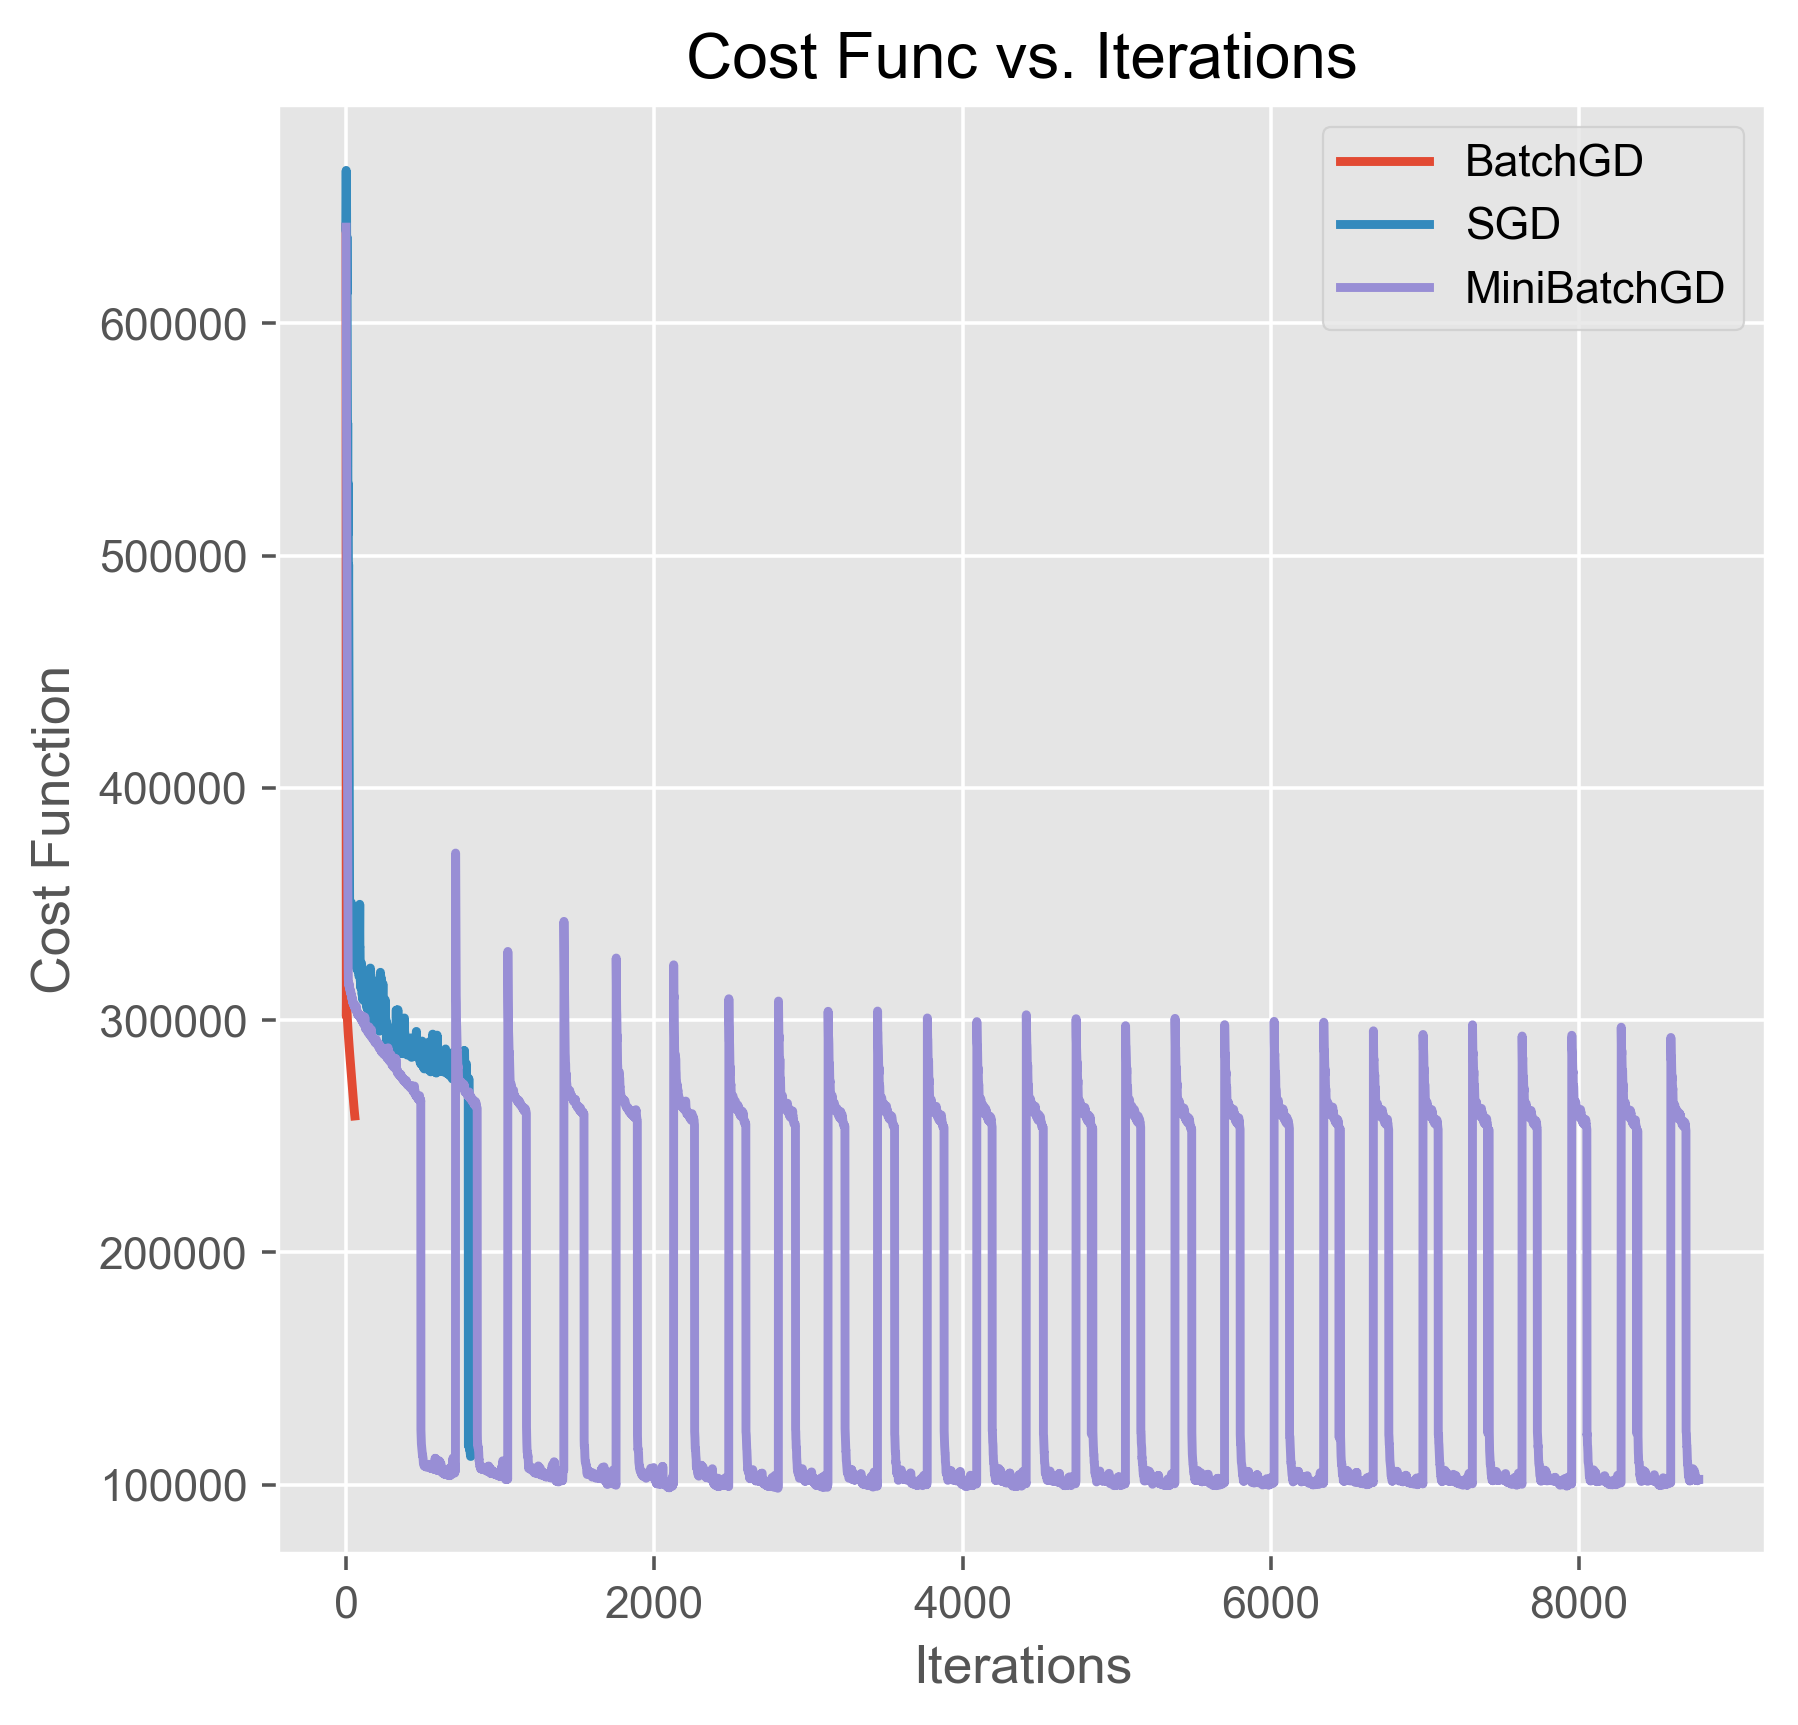

In [177]:
from matplotlib import cm
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams["font.weight"] = "bold"
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize = (6,6), dpi = 320)
ax.plot(
    np.arange(k_BatchGD + 1), 
    cost_list_BatchGD, 
    linewidth = 2, 
    label = 'BatchGD'
)
ax.plot(
    np.arange(k_SGD + 1), 
    cost_list_SGD, 
    linewidth = 2, 
    label = 'SGD'
)
ax.plot(
    np.arange(k_MiniBatchGD + 1), 
    cost_list_MiniBatchGD, 
    linewidth = 2, 
    label = 'MiniBatchGD'
)
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost Function')
ax.set_title('Cost Func vs. Iterations')
ax.legend()
plt.show()


According to this plot, we can note that BatchGD use extremely less number of iterations to converge, while SGD converged in 823 iterations, and MiniBatchGD converged in more than 8500 iterations. We can see that the cost function of BatchGD decreased without any fluctuation, while StochasticGD and MiniBatchGD have the fluctuation on the value of their cost functions. The time cost for convergence shows that the BatchGD converged in 1.53s, the SGD converged in 16.88s, and the MiniBatchGD converged in 178.49s, we can notice that MiniMatchGD was trapped in greate fluctuation of cost function, which made it converged much slower. However, MiniBatchGD finally got the minimal cost function value. 